# Text Clustering using Enron Emails

Unsupervised clustering using K-Means. This algorithm searches for a pre-determined number of clusters within a dataset. 

In [1]:
import pandas as pd
import email
import spacy
import textacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans
import sklearn
import mglearn

import matplotlib.pyplot as plt
%matplotlib inline

nlp = spacy.load('en')  # spacy

In [2]:
# Read in the dataset
df = pd.read_csv('../data/emails.csv')
print(df.iloc[0]['message'])  # Print what the data contains

Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 


In [3]:
'''
Data parsing and loading functions based from Zichen -- thank you for sharing your exploration!
Using this to better keep the information if we want it later it's easier to process. 
https://www.kaggle.com/zichen/explore-enron
'''
def get_text_from_email(msg):
    '''To get the content from email objects'''
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append( part.get_payload() )
    return ''.join(parts)

def split_email_addresses(line):
    '''To separate multiple email addresses'''
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs

# Parse the emails into a list email objects
messages = list(map(email.message_from_string, df['message']))
df.drop('message', axis=1, inplace=True)
# Get fields from parsed email objects
keys = messages[0].keys()
for key in keys:
    df[key] = [doc[key] for doc in messages]
# Parse content from emails
df['content'] = list(map(get_text_from_email, messages))
# Split multiple email addresses
df['From'] = df['From'].map(split_email_addresses)
df['To'] = df['To'].map(split_email_addresses)

# Extract the root of 'file' as 'user'
df['user'] = df['file'].map(lambda x:x.split('/')[0])
del messages

df.head(2)

,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
0,allen-p/_sent_mail/1.,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",(phillip.allen@enron.com),(tim.belden@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p
1,allen-p/_sent_mail/10.,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p


In [4]:
def clean_preprocess(doc):
    """ Function to clean and run the text pre-processing steps.
    1. Lowercase
    2. Punctuation
    3. Stopwords
    :param doc: string
    :returns: text
    """
    # Lowercase -- can be done in spacy doc object as doc.lower_
    doc = doc.lower()
    
    # Punctuation
    doc = textacy.preprocess.remove_punct(doc)
    
    # Stemming/lemmatization
    #doc = [w.lemma_ for w in nlp(doc)]
    
    # Stopwords (using spacy stopwords)
    doc = [w for w in doc.split(' ') if not w in spacy.en.STOP_WORDS]
    
    # Custom stopwords to remove
    rm = ['-PRON-']
    doc = [w for w in doc if not w in rm]
    
    # Additional normalization using textacy
    # doc = [textacy.preprocess_text(w) for w in doc]
    
    string = ' '.join(doc).replace('\n\n',' ').replace('\n', ' ')
    return string
    #return ' '.join(doc)

In [5]:
%time df['processed_content'] = df.content.apply(clean_preprocess)

CPU times: user 54.6 s, sys: 0 ns, total: 54.6 s
Wall time: 54.6 s


In [6]:
v = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english')
x = v.fit_transform(df['processed_content'])

In [ ]:
v.get_feature_names()[-500:]

## K-Means Clustering

In [ ]:
n = 2

clf = KMeans(n_clusters=n)
labels = clf.fit(x)

In [ ]:
sklearn.externals.joblib.dump(labels, 'kmeans.pkl')
#labels = sklearn.externals.joblib.load('kmeans.pkl')

In [ ]:
# Cluster memberships
print(labels.labels_[:100])

In [ ]:
len(labels.labels_)

## Minibatch K-Means

In [7]:
# Minibatch kmeans
clf_mb = MiniBatchKMeans(n_clusters=2)
%time mb_labels = clf_mb.fit(x)

CPU times: user 3.79 s, sys: 20 ms, total: 3.81 s
Wall time: 3.82 s


In [10]:
from sklearn.metrics import silhouette_score

labels_mb = clf_mb.labels_
centr = clf_mb.cluster_centers_
    
silhouette_score(x, labels_mb, metric='euclidean', sample_size=2000)  # runs out of memory if not sample size

0.001813760144224671

In [ ]:
plt.plot(s)
plt.ylabel('Silhouette')
plt.xlabel('K')
plt.show()

## Top Terms per cluster

Resources: http://brandonrose.org/clustering

In [ ]:
vocab_frame = pd.DataFrame({'words': v.get_feature_names()[:]}, index = v.get_feature_names()[:])

In [ ]:
order_centroids = clf.cluster_centers_.argsort()[:, ::-1] 

for i in range(2):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :20]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.ix[v.get_feature_names()[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

reduced_data = PCA(n_components=2).fit_transform(x)
kmeans = KMeans(init='k-means++', n_clusters=2, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [16]:
s = []

for n_clusters in range(2,12):
    k_mini = MiniBatchKMeans(n_clusters=n_clusters)
    k_mini.fit(x)
    
    labels = k_mini.labels_
    centr = k_mini.cluster_centers_
    
    s.append(silhouette_score(x, labels, metric='euclidean', sample_size=2000))

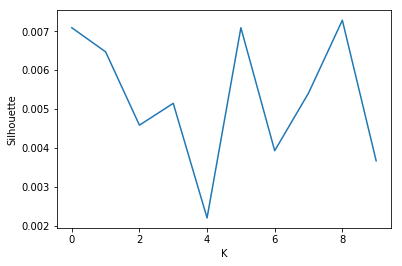

In [17]:
plt.plot(s)
plt.ylabel('Silhouette')
plt.xlabel('K')
plt.show()

## Resources

http://scikit-learn.org/stable/auto_examples/text/document_clustering.html

http://scikit-learn.org/stable/auto_examples/text/document_clustering.html#sphx-glr-auto-examples-text-document-clustering-py

http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py

http://brandonrose.org/clustering

https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html

https://www.kaggle.com/jaykrishna/topic-modeling-enron-email-dataset